# Mini-task-chem-2

## Установка библиотек

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn rdkit-pypi requests


In [2]:
!pip install numpy==1.26.4

## Импорт библиотек

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs import ConvertToNumpyArray
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


## 1. Загрузка данных из ChEMBL API

- Загрузка данных через ChEMBL API для рецептора CHEMBL206 с типом активности Ki и единицей измерения nM.

- Фильтрация по типу активности и единице измерения.

In [4]:
def fetch_chembl_data(chembl_target_id="CHEMBL206", activity_type="Ki", units="nM", max_records=1000):
    base = "https://www.ebi.ac.uk"  # неизменяемая часть пути

    # изменяемая часть:
    url = f"{base}/chembl/api/data/activity.json?target_chembl_id={chembl_target_id}&activity_type={activity_type}&units={units}&limit={max_records}"

    activities = []   # сюда будем сохранять результат

    while url:
        if url.startswith("/"):  # дополняем относительный путь
            url = base + url
        r = requests.get(url)
        r.raise_for_status()
        page = r.json()

        activities.extend(page["activities"])
        url = page.get("page_meta", {}).get("next", None)

    return pd.DataFrame(activities)  # возвращаем дата-фрейм


Посмотрим, что можно получить:

In [5]:
df_raw = fetch_chembl_data()
df_raw.head()

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,72003,[],CHEMBL679321,Binding affinity towards human estrogen recept...,B,None,None,BAO_0000190,...,Homo sapiens,Estrogen receptor alpha,9606,None,None,IC50,nM,UO_0000065,None,2.5
1,None,None,74062,[],CHEMBL679321,Binding affinity towards human estrogen recept...,B,None,None,BAO_0000190,...,Homo sapiens,Estrogen receptor alpha,9606,None,None,IC50,nM,UO_0000065,None,7.5
2,None,None,76289,[],CHEMBL679321,Binding affinity towards human estrogen recept...,B,None,None,BAO_0000190,...,Homo sapiens,Estrogen receptor alpha,9606,None,None,IC50,nM,UO_0000065,None,3.1
3,None,None,77402,[],CHEMBL679321,Binding affinity towards human estrogen recept...,B,None,None,BAO_0000190,...,Homo sapiens,Estrogen receptor alpha,9606,None,None,IC50,nM,UO_0000065,None,3.9
4,None,None,78475,[],CHEMBL679321,Binding affinity towards human estrogen recept...,B,None,None,BAO_0000190,...,Homo sapiens,Estrogen receptor alpha,9606,None,None,IC50,nM,UO_0000065,None,7.4


Информация о данных:

In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4187 entries, 0 to 4186
Data columns (total 46 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   action_type                676 non-null    object
 1   activity_comment           117 non-null    object
 2   activity_id                4187 non-null   int64 
 3   activity_properties        4187 non-null   object
 4   assay_chembl_id            4187 non-null   object
 5   assay_description          4187 non-null   object
 6   assay_type                 4187 non-null   object
 7   assay_variant_accession    77 non-null     object
 8   assay_variant_mutation     77 non-null     object
 9   bao_endpoint               4187 non-null   object
 10  bao_format                 4187 non-null   object
 11  bao_label                  4187 non-null   object
 12  canonical_smiles           4176 non-null   object
 13  data_validity_comment      14 non-null     object
 14  data_val

## 2. Преобразование активности из Ki в pKi

- Преобразование значений: pKi = -log10(Ki) в столбец pValue

- Удаление строк с пропущенными значениями

In [7]:
df = df_raw.copy()
df = df[df["standard_value"].notna()]
df["Ki_nM"] = pd.to_numeric(df["standard_value"], errors='coerce')
df = df[df["Ki_nM"] > 0]
df["pValue"] = -np.log10(df["Ki_nM"] * 1e-9)
df = df[["molecule_chembl_id", "pValue"]]
df.head()

,molecule_chembl_id,pValue
0,CHEMBL431611,8.602060
1,CHEMBL316132,8.124939
2,CHEMBL304552,8.508638
3,CHEMBL85881,8.408935
4,CHEMBL85536,8.130768


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4150 entries, 0 to 4186
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  4150 non-null   object 
 1   pValue              4150 non-null   float64
dtypes: float64(1), object(1)
memory usage: 97.3+ KB


## 3. Молекулярные дескрипторы и отпечатки Моргана

In [9]:
def fetch_smiles(chembl_ids):
    base = "https://www.ebi.ac.uk"   # неизменяемая часть запроса
    smiles_list = []    # сюда будем записывать результат

    for chembl_id in chembl_ids:
        endpoint = f"/chembl/api/data/molecule/{chembl_id}.json"
        url = base + endpoint     # полный путь
        try:
            r = requests.get(url, timeout=5)
            r.raise_for_status()
            data = r.json()
            smiles = data["molecule_structures"]["canonical_smiles"]
        except:
            smiles = None

        smiles_list.append((chembl_id, smiles))

    return pd.DataFrame(smiles_list, columns=["molecule_chembl_id", "smiles"])


In [10]:
unique_ids = df["molecule_chembl_id"].unique()   # выбор уникальных cid
df_smiles = fetch_smiles(unique_ids)   # находим smiles для их записи в таблицу

df = df.merge(df_smiles, on="molecule_chembl_id")  # объединяем полученное и то, что было
df = df[df["smiles"].notna()].reset_index(drop=True)
df.head() # смотрим

,molecule_chembl_id,pValue,smiles
0,CHEMBL431611,8.602060,Oc1ccc2c(c1)S[C@H](C1CCCC1)[C@H](c1ccc(OCCN3CC...
1,CHEMBL316132,8.124939,Oc1ccc2c(c1)S[C@H](C1CCCCCC1)[C@H](c1ccc(OCCN3...
2,CHEMBL304552,8.508638,Oc1ccc([C@H]2Sc3cc(O)ccc3O[C@H]2c2ccc(OCCN3CCC...
3,CHEMBL85881,8.408935,Oc1ccc2c(c1)S[C@H](CC1CCCCC1)[C@H](c1ccc(OCCN3...
4,CHEMBL85536,8.130768,Oc1ccc2c(c1)S[C@H](Cc1ccccc1)[C@H](c1ccc(OCCN3...


### Генерация отпечатков Моргана:

Генерация 1024-битных отпечатков Моргана с радиусом 2 для SMILES-строк.

In [11]:
def smiles_to_morgan_fp(smiles, radius=2, nBits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
    arr = np.zeros((1,))
    ConvertToNumpyArray(fp, arr)
    return arr

fps = df["smiles"].apply(smiles_to_morgan_fp)
fps = fps.dropna()
fp_matrix = np.array(fps.tolist())
df_filtered = df.loc[fps.index].reset_index(drop=True)

Просмотр полученных значений с учетом радиуса

In [12]:
df_filtered.head()

,molecule_chembl_id,pValue,smiles
0,CHEMBL431611,8.602060,Oc1ccc2c(c1)S[C@H](C1CCCC1)[C@H](c1ccc(OCCN3CC...
1,CHEMBL316132,8.124939,Oc1ccc2c(c1)S[C@H](C1CCCCCC1)[C@H](c1ccc(OCCN3...
2,CHEMBL304552,8.508638,Oc1ccc([C@H]2Sc3cc(O)ccc3O[C@H]2c2ccc(OCCN3CCC...
3,CHEMBL85881,8.408935,Oc1ccc2c(c1)S[C@H](CC1CCCCC1)[C@H](c1ccc(OCCN3...
4,CHEMBL85536,8.130768,Oc1ccc2c(c1)S[C@H](Cc1ccccc1)[C@H](c1ccc(OCCN3...


In [13]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4139 entries, 0 to 4138
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  4139 non-null   object 
 1   pValue              4139 non-null   float64
 2   smiles              4139 non-null   object 
dtypes: float64(1), object(2)
memory usage: 97.1+ KB


### Удаление признаков с низкой дисперсией:

In [14]:
selector = VarianceThreshold(threshold=0.01)
fp_matrix_reduced = selector.fit_transform(fp_matrix)
fp_matrix_reduced.shape


(4139, 680)

Получается, порог дисперсии прошли все

## 4. Снижение размерности с PCA

- Применение Principal Component Analysis (PCA) для снижения размерности и определения оптимального числа компонент, объясняющих ≥95% дисперсии.

- Стандартизация данных перед применением PCA.

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(fp_matrix_reduced)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Выбрано компонент: {X_pca.shape[1]}")


Выбрано компонент: 338


### Визуализация PCA

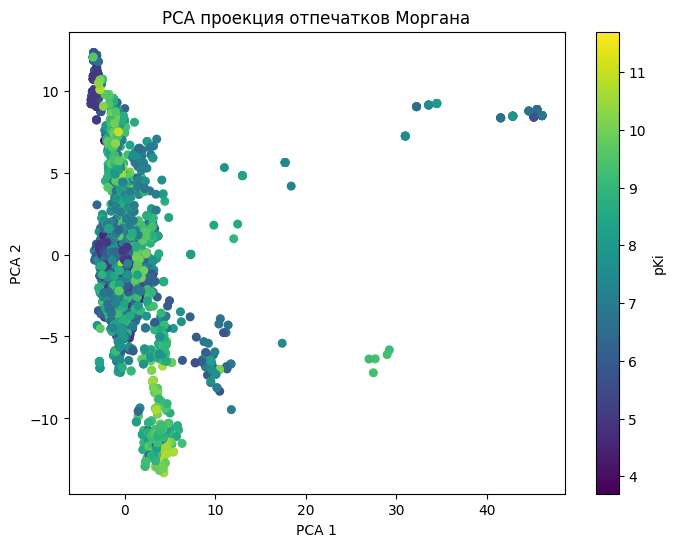

In [16]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df_filtered["pValue"], cmap="viridis", s=30)
plt.colorbar(label="pKi")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA проекция отпечатков Моргана")
plt.show()


## 5. Финальный датасет и сохранение

In [17]:
pca_df = pd.DataFrame(X_pca, columns=[f"pca_{i+1}" for i in range(X_pca.shape[1])])
final_df = pd.concat([df_filtered[["molecule_chembl_id", "smiles", "pValue"]], pca_df], axis=1)
final_df.to_csv("final_dataset_mini_task_2.csv", index=False)
final_df.head()

,molecule_chembl_id,smiles,pValue,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,...,pca_329,pca_330,pca_331,pca_332,pca_333,pca_334,pca_335,pca_336,pca_337,pca_338
0,CHEMBL431611,Oc1ccc2c(c1)S[C@H](C1CCCC1)[C@H](c1ccc(OCCN3CC...,8.602060,-1.609616,8.234091,2.940706,2.583355,1.546085,-1.396697,1.434167,...,-0.736954,-1.161829,-0.706288,0.118720,-0.124668,0.333873,0.871606,0.844265,-0.635906,-0.458644
1,CHEMBL316132,Oc1ccc2c(c1)S[C@H](C1CCCCCC1)[C@H](c1ccc(OCCN3...,8.124939,-1.609616,8.234091,2.940706,2.583355,1.546085,-1.396697,1.434167,...,-0.736954,-1.161829,-0.706288,0.118720,-0.124668,0.333873,0.871606,0.844265,-0.635906,-0.458644
2,CHEMBL304552,Oc1ccc([C@H]2Sc3cc(O)ccc3O[C@H]2c2ccc(OCCN3CCC...,8.508638,-1.280553,9.510941,3.628570,2.399689,0.767259,-1.809777,2.330975,...,-0.181232,-0.026129,0.194038,-0.066814,0.121559,-0.129269,0.075400,-0.073290,0.016178,0.060936
3,CHEMBL85881,Oc1ccc2c(c1)S[C@H](CC1CCCCC1)[C@H](c1ccc(OCCN3...,8.408935,-1.525144,8.122060,3.363503,2.317466,1.217481,-1.215100,2.204470,...,-0.474611,0.686109,-0.536986,0.427256,-0.306097,-0.509537,-1.246874,0.046200,0.287897,-0.421012
4,CHEMBL85536,Oc1ccc2c(c1)S[C@H](Cc1ccccc1)[C@H](c1ccc(OCCN3...,8.130768,-1.422023,7.419929,3.968279,1.449245,1.417217,-0.607714,1.427493,...,1.192889,0.075919,-1.239811,1.068463,0.065388,0.040411,-0.477352,-0.043882,0.286260,-0.431488
